In [ ]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.impute import KNNImputer
from sklearn.preprocessing import RobustScaler, OrdinalEncoder, StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import silhouette_score, accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from xgboost import XGBClassifier
from xgboost import XGBClassifier as SGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import r2_score
from google.colab import drive
drive.mount('/content/drive')
%matplotlib inline

file_path = '/content/drive/MyDrive/Thesis_De_Identified.xlsx'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def tune_hyperparameters(model, param_grid, X_train, y_train):
    """
    Tunes hyperparameters using GridSearchCV.

    Parameters:
    - model: sklearn estimator.
    - param_grid: dict, parameter grid for GridSearchCV.
    - X_train: pd.DataFrame, training features.
    - y_train: pd.Series or np.array, training labels.

    Returns:
    - best_model: sklearn estimator, model with best parameters.
    """
    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_weighted', n_jobs=-1)
    grid_search.fit(X_train, y_train)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_train)  # Get predictions on training data
    r2 = r2_score(y_train, y_pred)  # Calculate R-squared

    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best cross-validated score: {grid_search.best_score_:.3f}")
    print(f"R-squared on training data: {r2:.3f}")  # Print R-squared

    return best_model

In [ ]:
def compute_rom_differences(df):
    """
    Computes differences between 'Post' and 'Pre' ROM measurements.
    Only considers columns that have both 'Pre' and 'Post' counterparts.
    """
    rom_cols = [col for col in df.columns if ('Pre' in col or 'Post' in col)]
    pre_cols = [col for col in rom_cols if 'Pre' in col]

    differences = {}
    for pre_col in pre_cols:
        post_col = pre_col.replace('Pre', 'Post')
        if post_col in df.columns:
            diff_col = f"Diff_{pre_col.replace('Pre', '').strip('_')}"
            differences[diff_col] = df[post_col] - df[pre_col]
    diff_df = pd.DataFrame(differences)
    return diff_df

In [ ]:
def calculate_rmse(y_true, y_pred):
    """Calculates the Root Mean Squared Error (RMSE)."""
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    return rmse

In [ ]:
def feature_selection(X, y, k=50):
    """
    Selects the top k features based on the ANOVA F-test.

    Parameters:
    - X: pd.DataFrame, feature matrix.
    - y: pd.Series or np.array, target labels.
    - k: int, number of top features to select.

    Returns:
    - X_selected: pd.DataFrame, reduced feature matrix.
    - selected_features: list, names of selected features.
    """
    selector = SelectKBest(score_func=f_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_features = X.columns[selector.get_support(indices=True)]
    print(f"Feature Selection: Selected top {k} features.")
    return pd.DataFrame(X_selected, columns=selected_features), selected_features


In [ ]:
def load_and_preprocess_data(file_path, data_set='drop_rows', return_original=False):
    """
    Loads data from Excel, handles missing values, scales and encodes features,
    computes ROM differences, and returns a combined feature matrix.

    Parameters:
    - file_path: str, path to the Excel data file.
    - data_set: str, which dataset to use ('drop_rows', 'drop_cols_1', 'drop_cols_2').
                'drop_rows': Drops rows 8 and 17.
                'drop_cols_1': Drops columns containing "1" in their name.
                'drop_cols_2': Drops columns containing "2" in their name.
    """
    # Load data
    df = pd.read_excel(file_path)

    if return_original:  # Return original data if requested
        X = df.copy()
        # Remove ID if present, as it does not contribute to modeling
        if 'ID' in X.columns:
            X = X.drop(columns=['ID'], errors='ignore')
        return X

    #df = df.drop([8, 17])
    #df.replace(-99, np.nan, inplace=True)

    if data_set == 'drop_rows':
        # Drop rows 8 and 17
        df = df.drop([8, 17], axis=0).reset_index(drop=True)
    elif data_set == 'drop_cols_1':
        # Drop columns containing "1" in their name
        cols_to_drop = [col for col in df.columns if '1' in col and col != 'MassD1']
        df = df.drop(columns=cols_to_drop)
    elif data_set == 'drop_cols_2':
        # Drop columns containing "2" in their name
        cols_to_drop = [col for col in df.columns if '2' in col and col not in ['MassD2', 'Play#']]
        df = df.drop(columns=cols_to_drop)
    else:
        raise ValueError("Invalid data_set value. Choose from ['drop_rows', 'drop_cols_1', 'drop_cols_2'].")

    df_imputed = df

    # Dynamically determine demographic columns
    demographic_columns = df_imputed.columns[:11] if data_set != 'drop_cols_1' else df_imputed.columns[:10] # MassD1 removed, so 10 instead of 11
    demographic_columns = df_imputed.columns[:11] if data_set != 'drop_cols_2' else df_imputed.columns[:10] # MassD2 removed, so 10 instead of 11

    # Adjust goniometer columns based on demographic columns
    goniometer_columns = df_imputed.columns.difference(demographic_columns) # All columns except demographic

    # Split using column names
    demographic_data = df_imputed[demographic_columns].copy()
    goniometer_data = df_imputed[goniometer_columns].copy()

    # Compute ROM differences
    rom_differences = compute_rom_differences(df_imputed)

    # Define continuous and categorical features in demographics
    continuous_features = ['Age', 'MassD1', 'MassD2', 'Height', 'ShoeSize', 'Tegner']
    categorical_features = ['Gender', 'LegD', 'ArmD', 'Play#']
    # 'ID' is at index 0 and typically not used as a feature

    # Filter categorical_features to include only those present in demographic_data
    categorical_features = [feature for feature in categorical_features if feature in demographic_data.columns]

    # Scale continuous demographic features
    cont_scaler = RobustScaler()
    demographic_data[continuous_features] = cont_scaler.fit_transform(demographic_data[continuous_features])

    # Encode categorical demographic features
    cat_encoder = OrdinalEncoder()
    demographic_data[categorical_features] = cat_encoder.fit_transform(demographic_data[categorical_features])

    # Scale ROM differences if available
    if not rom_differences.empty:
        rom_scaler = RobustScaler()
        rom_differences = pd.DataFrame(rom_scaler.fit_transform(rom_differences), columns=rom_differences.columns)

    # Scale goniometer data
    gonio_scaler = RobustScaler()
    goniometer_data_scaled = pd.DataFrame(gonio_scaler.fit_transform(goniometer_data), columns=goniometer_data.columns)

    # Combine all features
    if not rom_differences.empty:
        X = pd.concat([demographic_data, goniometer_data_scaled, rom_differences], axis=1)
    else:
        X = pd.concat([demographic_data, goniometer_data_scaled], axis=1)

   # X = pd.concat([demographic_data, goniometer_data_scaled], axis=1)  # Combine only demographic and goniometer data

    # Remove ID if present, as it does not contribute to modeling
    if 'ID' in X.columns:
        X = X.drop(columns=['ID'], errors='ignore')

    return X

# Use this to look at pre processed scaled data that contain two days
X = load_and_preprocess_data(file_path, data_set='drop_rows', return_original=False)
#X = X[[col for col in X.columns if not col.startswith('Diff')]]
#X = X[[col for col in X.columns if not col.startswith(('Pre', 'Post'))]]

# Use this to obtain original data set that also drops missing values
#X = load_and_preprocess_data(file_path, data_set='drop_rows', return_original=True)
#X = X.drop([8, 17])

# Use this to look at either day 1 or day 2 alone
#X = load_and_preprocess_data(file_path, data_set='drop_cols_1', return_original=False)
#X = X.drop(columns=['MassD1'])
#X = X[[col for col in X.columns if not col.startswith('Diff')]]

#X = load_and_preprocess_data(file_path, data_set='drop_cols_2', return_original=False)
#X = X.drop(columns=['MassD2'])
#X = X[[col for col in X.columns if not col.startswith('Diff')]]

# Make sure to uncomment this last one to check before running
X.to_csv('exported_data.csv', index=False)

## Completed with CV of 5 and custer of 3
Original Pipeline
- top 3 most important: Pre1DPER, Pre1PAFR, Pre2DPFR

Running Original (no diff involved, but still scaled)
- Most Important Factor is Post2DAFR, Pre2PPFL, Pre1DPFR

Running Day 2 Only
- Most important Factor is Post2DAEL with cluster = 3 and CV = 5

Running Day 1 Only
- Most important Factor is Shoe Size with cluster = 3 and CV = 5

Running Ankle ROM only with demographics (bad stilhoutte score)
- Diff_DFPR & WB2DFL

In [ ]:
def dimensionality_reduction(X, method='tsne_pca', n_components=2, pca_components=10):
    """
    Applies dimensionality reduction. If method is 'tsne_pca', applies PCA followed by t-SNE.
    If method is 'tsne', applies t-SNE directly.
    """
    if method == 'tsne_pca':
        # First apply PCA
        pca = PCA(n_components=pca_components, random_state=42)
        X_pca = pca.fit_transform(X)
        print(f"PCA: Reduced to {pca_components} components.")
        # Then apply t-SNE
        tsne = TSNE(n_components=n_components, random_state=42, perplexity=5, learning_rate='auto')
        X_embedded = tsne.fit_transform(X_pca)
        print("t-SNE: Dimensionality reduction completed after PCA.")
        return X_embedded
    elif method == 'tsne':
        # Apply t-SNE directly
        tsne = TSNE(n_components=n_components, random_state=42, perplexity=5, learning_rate='auto')
        X_embedded = tsne.fit_transform(X)
        print("t-SNE: Dimensionality reduction completed directly.")
        return X_embedded
    else:
        raise ValueError("Unknown dimensionality reduction method. Choose from ['tsne_pca', 'tsne'].")

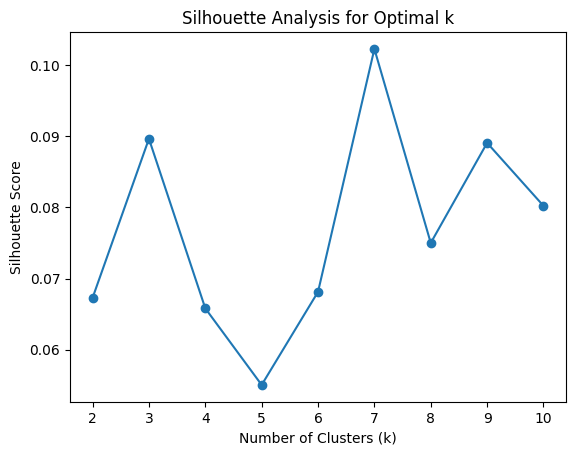

Estimated optimal number of clusters: 7


In [ ]:
# becuase small sample size
def find_optimal_k(X):
    silhouette_scores = []
    for k in range(2, 11):  # Try k from 2 to 10
        cluster_labels = KMeans(n_clusters=k, random_state=42).fit_predict(X)
        score = silhouette_score(X, cluster_labels)
        silhouette_scores.append(score)

    plt.plot(range(2, 11), silhouette_scores, marker='o')
    plt.title('Silhouette Analysis for Optimal k')
    plt.xlabel('Number of Clusters (k)')
    plt.ylabel('Silhouette Score')
    plt.show()

    optimal_k = range(2, 11)[silhouette_scores.index(max(silhouette_scores))]
    print(f"Estimated optimal number of clusters: {optimal_k}")
    return optimal_k

optimal_k = find_optimal_k(X)

In [ ]:
# Define how many clusters are needed
#(will affect cv = _ becuase can't be bigger than members in cluster)
# To find best K
#!pip install kneed
#import matplotlib.pyplot as plt
#from sklearn.cluster import KMeans
#from kneed import KneeLocator

#def find_optimal_k(X_embedded):
    #"""
    #Uses the elbow method with the kneed package to find the optimal number of clusters for KMeans.

    #Parameters:
    #- X_embedded: numpy array or pandas DataFrame, the data to cluster.

    #Returns:
    #- optimal_k: int, the estimated optimal number of clusters.
    #"""

    #wcss = []
    #for i in range(2, 21):  # Try k from 2 to 20
        #kmeans = KMeans(n_clusters=i, random_state=42)
        #kmeans.fit(X_embedded)
        #wcss.append(kmeans.inertia_)

    # Use KneeLocator to find the elbow point
    #kl = KneeLocator(range(2, 21), wcss, curve="convex", direction="decreasing")
    #optimal_k = kl.elbow

    # Plot the WCSS values and the elbow point
    #plt.plot(range(2, 21), wcss, marker='o')
    #plt.title('Elbow Method for Optimal k')
    #plt.xlabel('Number of Clusters (k)')
    #plt.ylabel('WCSS')
    #plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='r')  # Add vertical line at elbow point
    #plt.show()

    #return optimal_k

#X = load_and_preprocess_data(file_path)  # Load your data
#X_embedded = dimensionality_reduction(X, method='tsne_pca')  # Reduce dimensionality
#optimal_k = find_optimal_k(X_embedded)
#print(f"Estimated optimal number of clusters: {optimal_k}")

In [ ]:
def clustering(X, method='kmeans', n_clusters= 3): #optimal_k
    """
    Applies clustering algorithm on reduced data.
    """
    if method == 'kmeans':
        clusterer = KMeans(n_clusters=n_clusters, random_state=42)
        print("Clustering: Using KMeans.")
    elif method == 'agg':
        clusterer = AgglomerativeClustering(n_clusters=n_clusters)
        print("Clustering: Using Agglomerative Clustering.")
    else:
        raise ValueError("Unknown clustering method. Choose from ['kmeans', 'agg'].")
    labels = clusterer.fit_predict(X)
    return labels

In [ ]:
def train_classifier(X, y, method='logistic', tune=False, cv=5):
    """
    Trains a classifier on the data, optionally tunes hyperparameters,
    performs cross-validation, and evaluates it. Returns the trained model.

    Parameters:
    - X: pd.DataFrame, feature matrix.
    - y: pd.Series or np.array, target labels.
    - method: str, classifier method ('logistic', 'rf', 'nb').
    - tune: bool, whether to perform hyperparameter tuning.
    - cv: int, number of cross-validation folds.

    Returns:
    - dict, performance metrics and the trained model.
    """
    # Choose model and define parameter grid
    if method == 'logistic':
        model = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
        param_grid = {
            'C': [0.1, 1, 10],
            'solver': ['lbfgs', 'saga']
        }
        print("Classifier: Logistic Regression.")
    elif method == 'rf':
        model = RandomForestClassifier(n_estimators=100, random_state=42)
        param_grid = {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20],
            'min_samples_split': [2, 5]
        }
        print("Classifier: Random Forest.")
    elif method == 'nb':
        model = GaussianNB()
        param_grid = {}  # GaussianNB has no hyperparameters to tune
        print("Classifier: Naive Bayes.")
    elif method == 'svm':
        model = SVC(random_state=42)  # Initialize SVM
        param_grid = {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
        print("Classifier: Support Vector Machine.")
    elif method == 'gbdt':
        model = GradientBoostingClassifier(random_state=42) # Fixed indentation
        param_grid = {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7]
        }
        print("Classifier: Gradient Boosting Classifier.")
    else:
        raise ValueError("Unknown classifier method. Choose from ['logistic', 'rf', 'nb'].")

    # Before training the model, split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)  # Adjust test_size as needed

    # Hyperparameter Tuning
    if tune and param_grid:
        print("Tuning hyperparameters...")
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1)
        grid_search.fit(X, y)
        model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validated score: {grid_search.best_score_:.3f}")
    elif tune and not param_grid:
        print("No hyperparameters to tune for this classifier.")

    # Perform Cross-Validation
    if hasattr(model, "predict_proba"):
        scoring = 'f1_weighted'
    else:
        scoring = 'accuracy'

    cv_scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"Cross-Validated {scoring} Scores: {cv_scores}")
    print(f"Mean {scoring}: {cv_scores.mean():.3f}, Std: {cv_scores.std():.3f}")

    # Train on the entire dataset
    model.fit(X, y)
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average='weighted')

    # Calculate RMSE
    rmse = calculate_rmse(y, y_pred)
    print(f"RMSE: {rmse:.3f}")

    # Calculate R-squared (with caution for classification)
    r2 = r2_score(y, y_pred)
    print(f"R-squared: {r2:.3f}")  # Print R-squared for individual classifier

    print(f"Classifier Performance on Entire Dataset - Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")

    return {
        'model': method,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'trained_model': model,  # Include the trained model
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'r2': r2,
        'rmse': rmse
    }

    # Hyperparameter Tuning
    if tune and param_grid:
        print("Tuning hyperparameters...")
        grid_search = GridSearchCV(model, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1)
        grid_search.fit(X, y)
        model = grid_search.best_estimator_
        print(f"Best parameters: {grid_search.best_params_}")
        print(f"Best cross-validated score: {grid_search.best_score_:.3f}")
    elif tune and not param_grid:
        print("No hyperparameters to tune for this classifier.")

    # Perform Cross-Validation
    if hasattr(model, "predict_proba"):
        scoring = 'f1_weighted'
    else:
        scoring = 'accuracy'

    cv_scores = cross_val_score(model, X, y, cv=cv, scoring=scoring, n_jobs=-1)
    print(f"Cross-Validated {scoring} Scores: {cv_scores}")
    print(f"Mean {scoring}: {cv_scores.mean():.3f}, Std: {cv_scores.std():.3f}")

    # Train on the entire dataset
    model.fit(X, y)
    y_pred = model.predict(X)

    accuracy = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average='weighted')

    # Calculate R-squared (with caution for classification)
    r2 = r2_score(y, y_pred)
    print(f"R-squared: {r2:.3f}")

    print(f"Classifier Performance on Entire Dataset - Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")

    return {
        'model': method,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'trained_model': model,  # Include the trained model
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'r2': r2,
        'rmse': rmse
    }

In [ ]:
def model_fusion(X, y, fusion_models):
    """
    Creates a Voting Classifier ensemble, trains it, and evaluates its performance.

    Parameters:
    - X: pd.DataFrame, feature matrix.
    - y: pd.Series or np.array, target labels.
    - fusion_models: list of tuples, models to include in the ensemble.

    Returns:
    - dict, performance metrics and the trained ensemble model.
    """
    ensemble = VotingClassifier(estimators=fusion_models, voting='hard')
    ensemble.fit(X, y)
    y_pred = ensemble.predict(X)

    accuracy = accuracy_score(y, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y, y_pred, average='weighted')

    # Calculate R-squared (with caution for classification)
    r2 = r2_score(y, y_pred)
    print(f"Fusion Classifier R-squared: {r2:.3f}")  # Print R-squared

    print(f"Fusion Classifier Performance - Accuracy: {accuracy:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}, F1 Score: {f1:.3f}")

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'trained_model': ensemble,  # Include the trained ensemble model
        'r2': r2
    }

In [ ]:
def run_pipeline(X, file_path, dim_method='tsne_pca', cluster_method='kmeans', classifier_method='logistic',
                fusion_models=None, pca_components=10, feature_selection_k=None, tune=False, cv=5):
    """
    Executes the entire pipeline with specified methods, including optional feature selection and hyperparameter tuning.

    Parameters:
    - file_path: str, path to the Excel data file.
    - dim_method: str, dimensionality reduction method ('tsne', 'tsne_pca').
    - cluster_method: str, clustering algorithm ('kmeans', 'agg').
    - classifier_method: str, classifier ('logistic', 'rf', 'nb').
    - fusion_models: list of tuples, models to include in fusion.
    - pca_components: int, number of PCA components.
    - feature_selection_k: int or None, number of top features to select.
    - tune: bool, whether to perform hyperparameter tuning.
    - cv: int, number of cross-validation folds.

    Returns:
    - results: dict, performance metrics and configuration details including the trained model(s).
    """
    print("\n=== Running Pipeline ===")
    print(f"Dimensionality Reduction Method: {dim_method}")
    print(f"Clustering Method: {cluster_method}")
    print(f"Classifier Method: {classifier_method}")
    if fusion_models:
        print(f"Fusion Models: {[name for name, _ in fusion_models]}")
    if feature_selection_k:
        print(f"Feature Selection: Select top {feature_selection_k} features")
    if tune:
        print("Hyperparameter Tuning: Enabled")
    print("========================\n")

    # Dimensionality Reduction
    X_embedded = dimensionality_reduction(X, method=dim_method, n_components=2, pca_components=pca_components)

    # Clustering
    cluster_labels = clustering(X_embedded, method=cluster_method)
    unique_clusters = set(cluster_labels)

    results = {}
    if len(unique_clusters) > 1:
        # Compute silhouette score if >1 cluster
        sil_score = silhouette_score(X_embedded, cluster_labels)
        print(f"Silhouette Score: {sil_score:.3f}")
        results['silhouette_score'] = sil_score
    else:
        print("Only one cluster found, Silhouette Score not applicable.")
        results['silhouette_score'] = None

    # Feature Selection (Optional)
    if feature_selection_k:
        X_selected, selected_features = feature_selection(X, cluster_labels, k=feature_selection_k)
    else:
        X_selected = X
        selected_features = X.columns.tolist()

    # Treat cluster labels as pseudo labels for classification demonstration
    class_results = train_classifier(X_selected, cluster_labels, method=classifier_method, tune=tune, cv=cv)
    results.update(class_results)

    # Fusion if provided
    if fusion_models is not None:
        fusion_result = model_fusion(X_selected, cluster_labels, fusion_models)
        results.update({
            'fusion_accuracy': fusion_result['accuracy'],
            'fusion_precision': fusion_result['precision'],
            'fusion_recall': fusion_result['recall'],
            'fusion_f1': fusion_result['f1'],
            'fusion_trained_model': fusion_result['trained_model']  # Include the trained ensemble model
        })

    # Record methods used
    results['dim_method'] = dim_method
    results['cluster_method'] = cluster_method
    results['classifier_method'] = classifier_method
    results['selected_features'] = selected_features if feature_selection_k else 'None'
    results['hyperparameter_tuning'] = 'Enabled' if tune else 'Disabled'
    results['cross_validation_folds'] = cv
    results['rmse'] = class_results['rmse']
    return results


In [ ]:
# Cell9: Running Multiple Pipeline Configurations with Feature Selection and Trained Models

all_results = []

# 1. t-SNE Only + Agglomerative Clustering + Random Forest + Feature Selection
res_1_fs = run_pipeline(
    X,
    file_path,
    dim_method='tsne',
    cluster_method='agg',
    classifier_method='rf',
    feature_selection_k=10,    # Select top 10 features
    tune=True,                 # Enable hyperparameter tuning
    cv=5                        # 10-fold cross-validation
)
all_results.append(res_1_fs)

# 2. PCA + t-SNE + KMeans + Logistic Regression + Feature Selection
res_2_fs = run_pipeline(
    X,
    file_path,
    dim_method='tsne_pca',
    cluster_method='kmeans',
    classifier_method='logistic',
    pca_components=10,         # Adjust based on dataset size
    feature_selection_k=10,    # Select top 10 features
    tune=True,                  # Enable hyperparameter tuning
    cv=5                        # 10-fold cross-validation
)
all_results.append(res_2_fs)

# 3. PCA + t-SNE + KMeans + Naive Bayes + Feature Selection
res_3_fs = run_pipeline(
    X,
    file_path,
    dim_method='tsne_pca',
    cluster_method='kmeans',
    classifier_method='nb',
    pca_components=10,
    feature_selection_k=10,    # Select top 10 features
    tune=False,                 # Hyperparameter tuning not applicable for Naive Bayes
    cv=5                        # 10-fold cross-validation
)
all_results.append(res_3_fs)

# 4. PCA + t-SNE + Agglomerative Clustering + Logistic Regression + Feature Selection
res_4_fs = run_pipeline(
    X,
    file_path,
    dim_method='tsne_pca',
    cluster_method='agg',
    classifier_method='logistic',
    pca_components=10,
    feature_selection_k=10,    # Select top 10 features
    tune=True,                  # Enable hyperparameter tuning
    cv=5                        # 10-fold cross-validation
)
all_results.append(res_4_fs)

# 5. Fusion: PCA + t-SNE + KMeans + Voting Classifier (RF, NB, Logistic) + Feature Selection
fusion_models = [
    ('rf', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('nb', GaussianNB()),
    ('lr', LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42))
]
res_5_fs = run_pipeline(
    X,
    file_path,
    dim_method='tsne_pca',
    cluster_method='kmeans',
    classifier_method='rf',  # Base classifier for pseudo-labels
    fusion_models=fusion_models,
    pca_components=10,
    feature_selection_k=10,    # Select top 10 features
    tune=True,                  # Enable hyperparameter tuning for base classifier
    cv=5                        # 10-fold cross-validation
)
all_results.append(res_5_fs)

# 6. t-SNE Only + KMeans + Random Forest + Feature Selection
res_6_fs = run_pipeline(
    X,
    file_path,
    dim_method='tsne',
    cluster_method='kmeans',
    classifier_method='rf',
    feature_selection_k=10,    # Select top 10 features
    tune=True,                  # Enable hyperparameter tuning
    cv=5                        # 10-fold cross-validation
)
all_results.append(res_6_fs)

# 7. t-SNE Only + Agglomerative Clustering + Logistic Regression + Feature Selection
res_7_fs = run_pipeline(
    X,
    file_path,
    dim_method='tsne',
    cluster_method='agg',
    classifier_method='logistic',
    feature_selection_k=10,    # Select top 10 features
    tune=True,                  # Enable hyperparameter tuning
    cv=5                        # 10-fold cross-validation
)
all_results.append(res_7_fs)

# 8. t-SNE Only + KMeans + Naive Bayes + Feature Selection
res_8_fs = run_pipeline(
    X,
    file_path,
    dim_method='tsne',
    cluster_method='kmeans',
    classifier_method='nb',
    feature_selection_k=10,    # Select top 10 features
    tune=False,                 # Hyperparameter tuning not applicable for Naive Bayes
    cv=5                        # 10-fold cross-validation
)
all_results.append(res_8_fs)

# 9. t-SNE + PCA + KMeans + SVM + Feature Selection
res_svm = run_pipeline(
    X,
    file_path,
    dim_method='tsne_pca',  # Choose your preferred dimensionality reduction method
    cluster_method='kmeans', # Choose your preferred clustering method
    classifier_method='svm',
    pca_components=10,
    feature_selection_k=10,
    tune=True,
    cv=5
)
all_results.append(res_svm)

# 10. t-SNE + PCA + KMeans + GBDT + Feature Selection
res_gbdt = run_pipeline(
    X,
    file_path,
    dim_method='tsne_pca',
    cluster_method='kmeans',
    classifier_method='gbdt',
    pca_components=10,
    feature_selection_k=10,
    tune=True,
    cv=5
   )
all_results.append(res_gbdt)

# Convert to DataFrame for comparison
results_df = pd.DataFrame(all_results)
print("=== Pipeline Results ===")
display(results_df)


=== Running Pipeline ===
Dimensionality Reduction Method: tsne
Clustering Method: agg
Classifier Method: rf
Feature Selection: Select top 10 features
Hyperparameter Tuning: Enabled

t-SNE: Dimensionality reduction completed directly.
Clustering: Using Agglomerative Clustering.
Silhouette Score: 0.373
Feature Selection: Selected top 10 features.
Classifier: Random Forest.
Tuning hyperparameters...
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validated score: 0.766
Cross-Validated f1_weighted Scores: [0.83333333 0.65555556 0.55555556 1.         0.78666667]
Mean f1_weighted: 0.766, Std: 0.152
RMSE: 0.000
R-squared: 1.000
Classifier Performance on Entire Dataset - Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000

=== Running Pipeline ===
Dimensionality Reduction Method: tsne_pca
Clustering Method: kmeans
Classifier Method: logistic
Feature Selection: Select top 10 features
Hyperparameter Tuning: Enabled

PCA: Reduced to 10 c

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best parameters: {'C': 0.1, 'solver': 'lbfgs'}
Best cross-validated score: 0.694
Cross-Validated f1_weighted Scores: [0.76666667 0.76190476 0.62222222 0.6        0.72      ]
Mean f1_weighted: 0.694, Std: 0.070
RMSE: 0.719
R-squared: -0.016
Classifier Performance on Entire Dataset - Accuracy: 0.793, Precision: 0.656, Recall: 0.793, F1 Score: 0.718

=== Running Pipeline ===
Dimensionality Reduction Method: tsne_pca
Clustering Method: kmeans
Classifier Method: nb
Feature Selection: Select top 10 features

PCA: Reduced to 10 components.
t-SNE: Dimensionality reduction completed after PCA.
Clustering: Using KMeans.
Silhouette Score: 0.276
Feature Selection: Selected top 10 features.
Classifier: Naive Bayes.
Cross-Validated f1_weighted Scores: [0.83333333 0.83333333 0.46666667 0.42222222 0.4       ]
Mean f1_weighted: 0.591, Std: 0.199
RMSE: 0.947
R-squared: -0.762
Classifier Performance on Entire Dataset - Accuracy: 0.724, Precision: 0.836, Recall: 0.724, F1 Score: 0.750

=== Running Pipelin

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'C': 0.1, 'solver': 'lbfgs'}
Best cross-validated score: 0.839
Cross-Validated f1_weighted Scores: [1.         0.84920635 0.81746032 0.81481481 0.71111111]
Mean f1_weighted: 0.839, Std: 0.093
RMSE: 0.322
R-squared: 0.772
Classifier Performance on Entire Dataset - Accuracy: 0.897, Precision: 0.894, Recall: 0.897, F1 Score: 0.894

=== Running Pipeline ===
Dimensionality Reduction Method: tsne_pca
Clustering Method: kmeans
Classifier Method: rf
Fusion Models: ['rf', 'nb', 'lr']
Feature Selection: Select top 10 features
Hyperparameter Tuning: Enabled

PCA: Reduced to 10 components.
t-SNE: Dimensionality reduction completed after PCA.
Clustering: Using KMeans.
Silhouette Score: 0.276
Feature Selection: Selected top 10 features.
Classifier: Random Forest.
Tuning hyperparameters...
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best cross-validated score: 0.665
Cross-Validated f1_weighted Scores: [1.         0.76190476 0.28571429 0.55555556

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fusion Classifier R-squared: 0.729
Fusion Classifier Performance - Accuracy: 0.966, Precision: 0.968, Recall: 0.966, F1 Score: 0.964

=== Running Pipeline ===
Dimensionality Reduction Method: tsne
Clustering Method: kmeans
Classifier Method: rf
Feature Selection: Select top 10 features
Hyperparameter Tuning: Enabled

t-SNE: Dimensionality reduction completed directly.
Clustering: Using KMeans.
Silhouette Score: 0.380
Feature Selection: Selected top 10 features.
Classifier: Random Forest.
Tuning hyperparameters...
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validated score: 0.778
Cross-Validated f1_weighted Scores: [0.82222222 0.82222222 0.67777778 0.76666667 0.8       ]
Mean f1_weighted: 0.778, Std: 0.054
RMSE: 0.000
R-squared: 1.000
Classifier Performance on Entire Dataset - Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000

=== Running Pipeline ===
Dimensionality Reduction Method: tsne
Clustering Method: agg
Classifier 

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Best parameters: {'C': 0.1, 'solver': 'lbfgs'}
Best cross-validated score: 0.757
Cross-Validated f1_weighted Scores: [0.83333333 0.66666667 0.5        1.         0.78666667]
Mean f1_weighted: 0.757, Std: 0.167
RMSE: 0.263
R-squared: 0.885
Classifier Performance on Entire Dataset - Accuracy: 0.931, Precision: 0.934, Recall: 0.931, F1 Score: 0.930

=== Running Pipeline ===
Dimensionality Reduction Method: tsne
Clustering Method: kmeans
Classifier Method: nb
Feature Selection: Select top 10 features

t-SNE: Dimensionality reduction completed directly.
Clustering: Using KMeans.
Silhouette Score: 0.380
Feature Selection: Selected top 10 features.
Classifier: Naive Bayes.
Cross-Validated f1_weighted Scores: [0.65555556 0.82222222 0.49444444 1.         0.6       ]
Mean f1_weighted: 0.714, Std: 0.178
RMSE: 0.557
R-squared: 0.470
Classifier Performance on Entire Dataset - Accuracy: 0.793, Precision: 0.790, Recall: 0.793, F1 Score: 0.790

=== Running Pipeline ===
Dimensionality Reduction Method:

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Best parameters: {'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 200}
Best cross-validated score: 0.605
Cross-Validated f1_weighted Scores: [0.83333333 0.65079365 0.45238095 0.36666667 0.72      ]
Mean f1_weighted: 0.605, Std: 0.172
RMSE: 0.000
R-squared: 1.000
Classifier Performance on Entire Dataset - Accuracy: 1.000, Precision: 1.000, Recall: 1.000, F1 Score: 1.000
=== Pipeline Results ===


,silhouette_score,model,cv_mean,cv_std,trained_model,accuracy,precision,recall,f1,r2,...,cluster_method,classifier_method,selected_features,hyperparameter_tuning,cross_validation_folds,fusion_accuracy,fusion_precision,fusion_recall,fusion_f1,fusion_trained_model
0,0.372915,rf,0.766222,0.152448,"(DecisionTreeClassifier(max_features='sqrt', r...",1.000000,1.000000,1.000000,1.000000,1.000000,...,agg,rf,"Index(['Post1PAFL', 'Post1PPER', 'Post2DAFR', ...",Enabled,5,NaN,NaN,NaN,NaN,NaN
1,0.276125,logistic,0.694159,0.070079,"LogisticRegression(C=0.1, max_iter=1000, multi...",0.793103,0.656001,0.793103,0.717994,-0.016355,...,kmeans,logistic,"Index(['Post1PAER', 'Post1PPER', 'Post2PAER', ...",Enabled,5,NaN,NaN,NaN,NaN,NaN
2,0.276125,nb,0.591111,0.198935,GaussianNB(),0.724138,0.836095,0.724138,0.750000,-0.761682,...,kmeans,nb,"Index(['Post1PAER', 'Post1PPER', 'Post2PAER', ...",Disabled,5,NaN,NaN,NaN,NaN,NaN
3,0.457246,logistic,0.838519,0.093197,"LogisticRegression(C=0.1, max_iter=1000, multi...",0.896552,0.894253,0.896552,0.893899,0.772251,...,agg,logistic,"Index(['Age', 'Post2PAFR', 'Post2PPFR', 'Pre1P...",Enabled,5,NaN,NaN,NaN,NaN,NaN
4,0.276125,rf,0.664635,0.236844,"(DecisionTreeClassifier(max_features='sqrt', r...",1.000000,1.000000,1.000000,1.000000,1.000000,...,kmeans,rf,"Index(['Post1PAER', 'Post1PPER', 'Post2PAER', ...",Enabled,5,0.965517,0.968391,0.965517,0.964351,"VotingClassifier(estimators=[('rf', RandomFore..."
5,0.380068,rf,0.777778,0.053978,"(DecisionTreeClassifier(max_features='sqrt', r...",1.000000,1.000000,1.000000,1.000000,1.000000,...,kmeans,rf,"Index(['Post1DAER', 'Post1DAFR', 'Post1DPER', ...",Enabled,5,NaN,NaN,NaN,NaN,NaN
6,0.372915,logistic,0.757333,0.167311,"LogisticRegression(C=0.1, max_iter=1000, multi...",0.931034,0.933908,0.931034,0.930458,0.885375,...,agg,logistic,"Index(['Post1PAFL', 'Post1PPER', 'Post2DAFR', ...",Enabled,5,NaN,NaN,NaN,NaN,NaN
7,0.380068,nb,0.714444,0.177833,GaussianNB(),0.793103,0.790282,0.793103,0.790263,0.469512,...,kmeans,nb,"Index(['Post1DAER', 'Post1DAFR', 'Post1DPER', ...",Disabled,5,NaN,NaN,NaN,NaN,NaN
8,0.276125,svm,0.726667,0.128927,"SVC(C=1, gamma='auto', random_state=42)",0.758621,0.680077,0.758621,0.698672,-0.490654,...,kmeans,svm,"Index(['Post1PAER', 'Post1PPER', 'Post2PAER', ...",Enabled,5,NaN,NaN,NaN,NaN,NaN
9,0.276125,gbdt,0.604635,0.171786,([DecisionTreeRegressor(criterion='friedman_ms...,1.000000,1.000000,1.000000,1.000000,1.000000,...,kmeans,gbdt,"Index(['Post1PAER', 'Post1PPER', 'Post2PAER', ...",Enabled,5,NaN,NaN,NaN,NaN,NaN


Below is visualization for the above processes

In [ ]:
# If you only need the labels and counts for a specific configuration (e.g., the best one):
best_config_index = results_df['cv_mean'].idxmax()  # Assuming 'cv_mean' is the metric for comparison
best_trained_model = results_df.loc[best_config_index, 'trained_model']

# Get X_selected from the best run
# Assuming all_results is a list containing the results of each run
best_run = all_results[best_config_index]

# Instead of reloading and preprocessing the data, use the selected features from the best run:
X_selected = load_and_preprocess_data(file_path)  # Load and preprocess entire data
# Ensure X_selected uses only the features the best model was trained on
if isinstance(best_run['selected_features'], list):  # Check if feature selection was applied
    X_selected = X_selected[best_run['selected_features']]  # Use the selected features for prediction

# Before prediction, make sure X_selected has the same columns as during training
training_features = best_trained_model.feature_names_in_  # Get feature names from the trained model
X_selected = X_selected.reindex(columns=training_features, fill_value=0)  # Reindex and fill missing values if any

best_cluster_labels = best_trained_model.predict(X_selected)
best_class_counts = pd.Series(best_cluster_labels).value_counts()
print("Class Counts for Best Configuration:\n", best_class_counts)

Class Counts for Best Configuration:
 0    20
1     6
2     3
Name: count, dtype: int64


In [ ]:
def plot_performance_bar(results_df):
    """
    Plots a bar chart of cross-validated mean scores with error bars for standard deviation.

    Parameters:
    - results_df: pd.DataFrame, contains pipeline results.
    """
    plt.figure(figsize=(12, 6))

    # Create a unique identifier for each run
    results_df = results_df.copy()
    results_df['Run'] = results_df.index + 1

    # Sort runs by cv_mean for better visualization
    results_df_sorted = results_df.sort_values(by='cv_mean', ascending=False)

    # Create the barplot without error bars
    ax = sns.barplot(
        x='Run',
        y='cv_mean',
        data=results_df_sorted,
        palette='viridis',  # You can choose any palette you prefer
        ci=None
    )

    # Add error bars manually
    ax.errorbar(
        x=np.arange(len(results_df_sorted)),
        y=results_df_sorted['cv_mean'],
        yerr=results_df_sorted['cv_std'],
        fmt='none',
        c='black',
        capsize=5
    )

    plt.title('Classification Performance Across Pipeline Configurations')
    plt.xlabel('Pipeline Configuration (Run Number)')
    plt.ylabel('Cross-Validated Mean F1 Score')
    plt.ylim(0, 1)  # Assuming F1 scores range between 0 and 1
    plt.show()

def plot_silhouette_scores(results_df):
    """
    Plots a bar chart of silhouette scores for each pipeline configuration.

    Parameters:
    - results_df: pd.DataFrame, contains pipeline results.
    """
    plt.figure(figsize=(12, 6))

    # Create a unique identifier for each run
    results_df = results_df.copy()
    results_df['Run'] = results_df.index + 1

    # Sort runs by silhouette score
    results_df_sorted = results_df.sort_values(by='silhouette_score', ascending=False)

    sns.barplot(
        x='Run',
        y='silhouette_score',
        data=results_df_sorted,
        color='salmon'  # Assign a single color to avoid palette deprecation warning
    )

    plt.title('Silhouette Scores Across Pipeline Configurations')
    plt.xlabel('Pipeline Configuration (Run Number)')
    plt.ylabel('Silhouette Score')
    plt.ylim(-1, 1)  # Silhouette scores range from -1 to 1
    plt.show()

def plot_performance_vs_silhouette(results_df):
    """
    Plots a scatter plot of classification performance vs. silhouette scores.

    Parameters:
    - results_df: pd.DataFrame, contains pipeline results.
    """
    plt.figure(figsize=(10, 6))

    sns.scatterplot(
        x='silhouette_score',
        y='cv_mean',
        hue='classifier_method',
        style='cluster_method',
        s=100,
        data=results_df,
        palette='deep'
    )

    plt.title('Classification Performance vs. Clustering Quality')
    plt.xlabel('Silhouette Score')
    plt.ylabel('Cross-Validated Mean F1 Score')
    plt.xlim(-1, 1)
    plt.ylim(0, 1)
    plt.legend(title='Classifier / Clustering Method')
    plt.show()

def plot_fusion_performance(results_df):
    """
    Plots a bar chart comparing fusion model performance to individual classifiers.

    Parameters:
    - results_df: pd.DataFrame, contains pipeline results.
    """
    plt.figure(figsize=(10, 6))

    # Identify fusion models
    fusion_runs = results_df[results_df['fusion_accuracy'].notna()]
    individual_runs = results_df[results_df['fusion_accuracy'].isna()]

    # Create a unique identifier for each run
    individual_runs = individual_runs.copy()
    individual_runs['Run'] = individual_runs.index + 1
    fusion_runs = fusion_runs.copy()
    fusion_runs['Run'] = fusion_runs.index + 1

    # Plot individual classifiers
    sns.barplot(
        x='Run',
        y='cv_mean',
        data=individual_runs,
        color='skyblue',
        label='Individual Classifier'
    )

    # Plot fusion classifiers
    sns.barplot(
        x='Run',
        y='fusion_accuracy',
        data=fusion_runs,
        color='salmon',
        label='Fusion Model'
    )

    plt.title('Fusion Model Performance vs. Individual Classifiers')
    plt.xlabel('Pipeline Configuration (Run Number)')
    plt.ylabel('Mean F1 Score / Fusion Accuracy')
    plt.legend()
    plt.ylim(0, 1)
    plt.show()

# Define the plot_feature_importance function if not already defined
def plot_feature_importance(model, feature_names, top_n=10):
    """
    Plots the top_n feature importances for a given model.

    Parameters:
    - model: Trained sklearn estimator with feature_importances_ or coef_ attribute.
    - feature_names: list, names of the features.
    - top_n: int, number of top features to display.
    """
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # For Logistic Regression, use absolute values of coefficients
        importances = np.abs(model.coef_).mean(axis=0)
    else:
        raise AttributeError("The model does not have feature_importances_ or coef_ attribute.")

    # Define the rescale_feature_importance function to normalize the importances
    def rescale_feature_importance(importances):
        """Rescales feature importances to sum to 100."""
        return (importances / importances.sum()) * 100 # <--- THIS WAS ALREADY DONE. IGNORE

    # Rescale the feature importances to sum to 100
    importances = rescale_feature_importance(importances) # <--- rescale_feature_importance is called here already

    # Normalize importances to 0-100 by dividing by the max and multiplying by 100
    importances = (importances / importances.max()) * 100  # Normalize to 0-100 <--- ADDED THIS LINE

    # Create a DataFrame for easier visualization (optional)
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances  # Use rescaled importances here
    }).sort_values(by='importance', ascending=False).head(top_n)

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x='importance',
        y='feature',
        data=feature_importance_df,
        palette='viridis'
    )

    plt.title(f'Top {top_n} Feature Importances')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()


=== Run # Table ===
Run 1: t-SNE Only + Agglomerative Clustering + Random Forest + Feature Selection
Run 2: PCA + t-SNE + KMeans + Logistic Regression + Feature Selection
Run 3: PCA + t-SNE + KMeans + Naive Bayes + Feature Selection
Run 4: PCA + t-SNE + Agglomerative Clustering + Logistic Regression + Feature Selection
Run 5: Fusion: PCA + t-SNE + KMeans + Voting Classifier (RF, NB, Logistic) + Feature Selection
Run 6: t-SNE Only + KMeans + Random Forest + Feature Selection
Run 7:  t-SNE Only + Agglomerative Clustering + Logistic Regression + Feature Selection
Run 8: t-SNE Only + KMeans + Naive Bayes + Feature Selection
Run 9: t-SNE + PCA + KMeans + SVM + Feature Selection
Run 10: t-SNE + PCA + KMeans + GBDT + Feature Selection


<ipython-input-125-1e1340456b1d>:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(
<ipython-input-125-1e1340456b1d>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


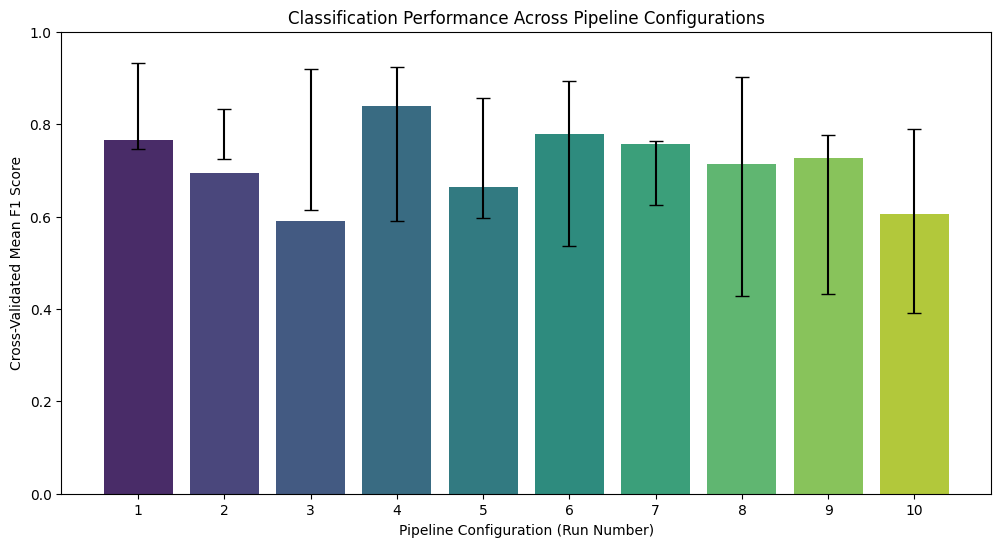

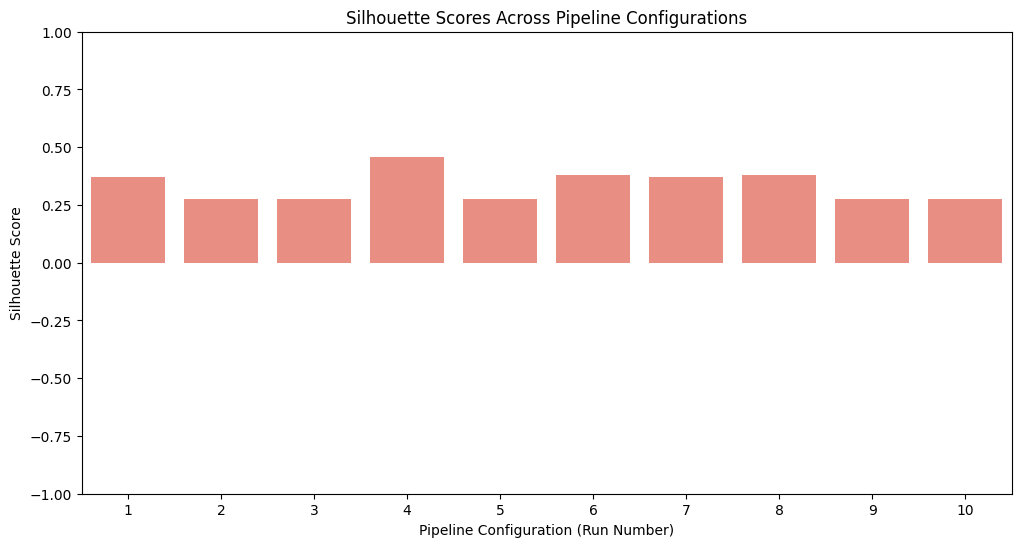

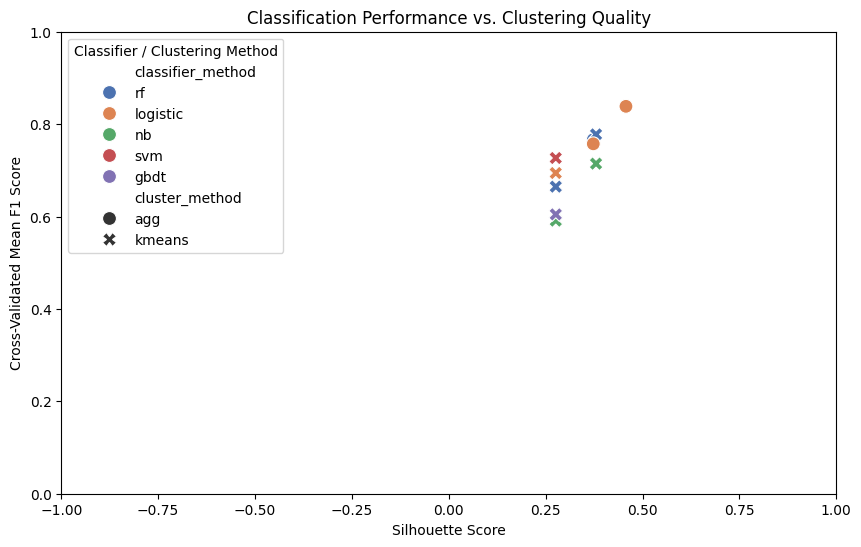

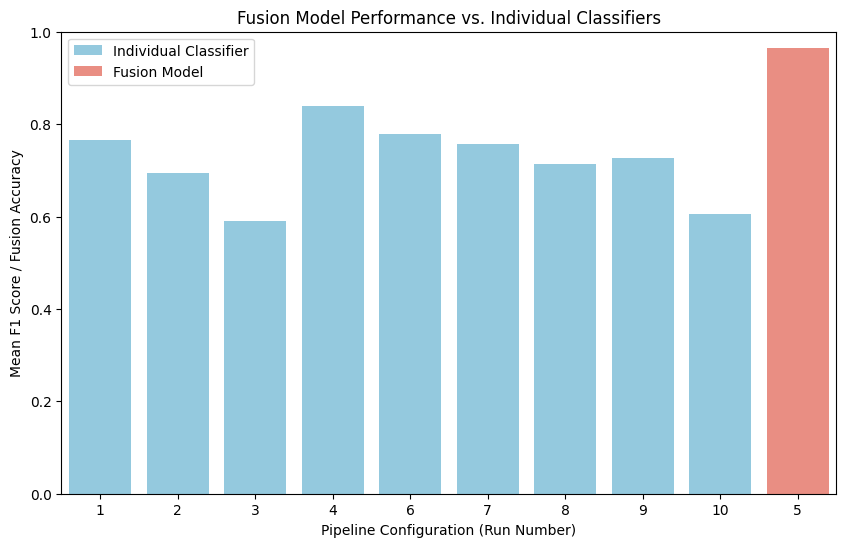

<ipython-input-125-1e1340456b1d>:178: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


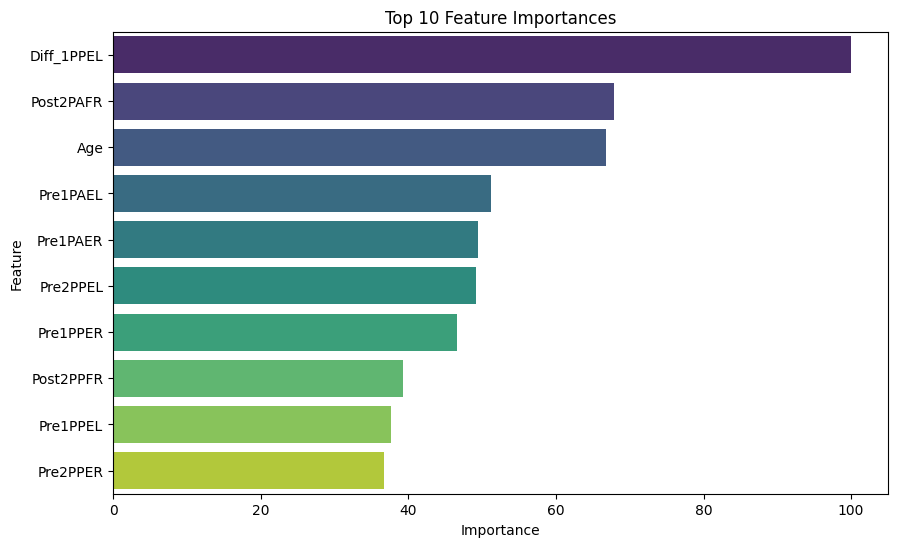

In [ ]:
print("=== Run # Table ===")
print("Run 1: t-SNE Only + Agglomerative Clustering + Random Forest + Feature Selection")
print("Run 2: PCA + t-SNE + KMeans + Logistic Regression + Feature Selection")
print("Run 3: PCA + t-SNE + KMeans + Naive Bayes + Feature Selection")
print("Run 4: PCA + t-SNE + Agglomerative Clustering + Logistic Regression + Feature Selection")
print("Run 5: Fusion: PCA + t-SNE + KMeans + Voting Classifier (RF, NB, Logistic) + Feature Selection")
print("Run 6: t-SNE Only + KMeans + Random Forest + Feature Selection")
print("Run 7:  t-SNE Only + Agglomerative Clustering + Logistic Regression + Feature Selection")
print("Run 8: t-SNE Only + KMeans + Naive Bayes + Feature Selection")
print("Run 9: t-SNE + PCA + KMeans + SVM + Feature Selection")
print("Run 10: t-SNE + PCA + KMeans + GBDT + Feature Selection")

'''
silhouette score is a metric used to evaluate the quality of a clustering algorithm's results. It provides a measure of how similar
each data point is to its assigned cluster (cohesion) compared to other clusters (separation). The silhouette score ranges from -1 to 1, where:

1: The sample is far away from neighboring clusters and well matched to its own cluster (ideal clustering).
0: The sample is on or very close to the decision boundary between two clusters (neutral clustering).
-1: The sample is closer to a neighboring cluster than to its own cluster (poor clustering).
'''



# Execute all plots with the corrected functions
plot_performance_bar(results_df)
plot_silhouette_scores(results_df)
plot_performance_vs_silhouette(results_df)
plot_fusion_performance(results_df)

# Identify and plot feature importance for the best run
best_run_index = results_df['cv_mean'].idxmax()
best_run = all_results[best_run_index]
selected_features_best_run = best_run['selected_features']
trained_model_best_run = best_run['trained_model']

plot_feature_importance(trained_model_best_run, selected_features_best_run, top_n=10)